# Apr 2nd, 2022 (quality control: both modalities)

**Motivation**: First I plot GS and tSNR and so on for both BOLD and Ca. I also check the RABIES preprocessed data. <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


def _plot_ca(figsize=(12, 8), highpass: bool = False):
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gspec = GridSpec(4, 6, height_ratios=[1.3] + [1] * 3, width_ratios=[1] + [1.3] + [1] * 4)

    ax = fig.add_subplot(gspec[0, :])
    ax.plot(gs_full, color='yellow', alpha=0.7, lw=0.8)
    ax.plot(gs_good, color='k', alpha=0.8, lw=0.8, label='GS good')
    ax.plot(gs_bad, color='r',  alpha=0.6, lw=0.8, label='GS bad')
    ax.legend()
    ax.grid()

    data2p = {
        r'$\mu$': mu,
        r'$\sigma$': sd,
        r'$tSNR = \frac{|\mu|}{\sigma}$': tsnr,
    }
    for i, (lbl, x2p) in enumerate(data2p.items(), start=1):
        ax = fig.add_subplot(gspec[i, 0])
        ax.imshow(x2p, cmap='Spectral' if 'tSNR' in lbl else 'rocket')
        ax.set_ylabel(lbl, labelpad=10, fontsize=15)
        remove_ticks(ax)

        ax_hist = fig.add_subplot(gspec[i, 1])
        sns.histplot(x2p[m], kde=True, color='dimgrey', ax=ax_hist)
        ax_hist.set_ylabel('')
        ax_hist.tick_params(axis='y', labelleft=False)

        for j, q in enumerate([0.01, 0.05, 0.10, 0.15]):
            ax = fig.add_subplot(gspec[i, 2 + j])
            if 'tSNR' in lbl:
                thres = np.quantile(x2p[m], q)
                good_pix = x2p > thres
            else:
                thres = np.quantile(x2p[m], 1 - q)
                good_pix = x2p < thres
            ax_hist.axvline(thres, color=f'C{j}', lw=1.2, ls='--')
            ax.imshow(m * good_pix, cmap=sns.dark_palette(f'C{j}', as_cmap=True, reverse=False))
            ax.set_ylabel(f'thres = {thres:0.2f}', fontsize=11)
            if 'tSNR' in lbl:
                ax.set_xlabel(f"q = {q}", fontsize=15)
            remove_ticks(ax)
            
    title = f"{f.split('/')[-1]}"
    if highpass:
        title += "  . . .  HP (0.001 Hz)"
    sup = fig.suptitle(title, fontsize=14, y=0.93)
    plt.close()
    
    return fig, sup


def _plot_bold(raw: bool = True, normalize: bool = True):
    fig = plt.figure(figsize=(13, 7.), constrained_layout=True)
    gspec = GridSpec(4, 7, height_ratios=[1.3] + [1] * 3, width_ratios=[1.5, 1.2, 1, 0.8]+ [1.1] * 2 + [1.0])

    ax = fig.add_subplot(gspec[0, :])
    if normalize:
        ax.plot(ner.fit_transform(gs_full.reshape(1, -1)).squeeze(), color='yellow', alpha=0.7, lw=2, label='GS full')
        ax.plot(ner.fit_transform(gs_good.reshape(1, -1)).squeeze(), color='k', alpha=0.8, lw=2, label='GS good')
        ax.plot(ner.fit_transform(gs_bad.reshape(1, -1)).squeeze(), color='r',  alpha=0.7, lw=2, label='GS bad')
    else:
        ax.plot(gs_full, color='yellow', alpha=0.7, lw=2, label='GS full')
        ax.plot(gs_good, color='k', alpha=0.8, lw=2, label='GS good')
        ax.plot(gs_bad, color='r',  alpha=0.7, lw=2, label='GS bad')        
    ax.legend()
    ax.grid()

    data2plt = {
        'mu': mu,
        'sd': sd,
        'tSNR': tsnr,
    }
    for ii, (lbl, xx) in enumerate(data2plt.items()):
        ax = fig.add_subplot(gspec[ii + 1, -1])
        sns.histplot(xx[m].ravel(), kde=True, label=lbl, ax=ax)
        ax.set_ylabel('')
        ax.set_yticks([])

        if raw and 'tSNR' in lbl:
            ax.axvline(thres, color='r', lw='1.2', ls='--', label=f"{thres:0.2f}")
        elif not raw and 'sd' in lbl:
            ax.axvline(thres, color='r', lw='1.2', ls='--', label=f"{thres:0.2f}")

        ax.legend()

        for jj, sl in enumerate(slices):
            ax = fig.add_subplot(gspec[ii + 1, 2 * jj])
            x2p = xx.take(sl, axis=jj)
            m2p = m.take(sl, axis=jj)
            x2p, m2p = filter_boundaries([x2p, m2p], m2p)
            if jj == 2:
                x2p = x2p.T
            ax.imshow(x2p, cmap='Spectral' if lbl == 'tSNR' else 'rocket')
            remove_ticks(ax)

            ax = fig.add_subplot(gspec[ii + 1, 2 * jj + 1])
            x2p = xx.take(sl + slices_delta[jj], axis=jj)
            m2p = m.take(sl + slices_delta[jj], axis=jj)
            x2p, m2p = filter_boundaries([x2p, m2p], m2p)
            if jj == 2:
                x2p = x2p.T
            ax.imshow(x2p, cmap='Spectral' if lbl == 'tSNR' else 'rocket')
            remove_ticks(ax)
    title = f.split('/')[-1]
    if raw:
        title += '  . . .  (RAW)'
    else:
        title += '  . . .  (CLEANED)'
    sup = fig.suptitle(title, fontsize=14, y=0.95)
    plt.close()
    
    return fig, sup

## Fig dir

In [3]:
fig_dir = pjoin(fig_dir, 'quality_control')
os.makedirs(fig_dir, exist_ok=True)

## tSNR CA2

In [4]:
set_style()

save_dir = pjoin(fig_dir, 'CA2')
os.makedirs(save_dir, exist_ok=True)

In [5]:
pth = '/mnt/storage/hadi/Ca-fMRI/PreprocessedDataBIDS'
paths = []
for p in pathlib.Path(pth).rglob('*.nii.gz'):
    if 'run' in p.name:
        paths.append(str(p))
paths = sorted(paths)

In [6]:
q = 0.05
tstart = 1000

for sub in range(1, 10 + 1):
    for ses in range(1, 3 + 1):
        figs, sups = [], []
        for run in range(1, 7 + 1):
            pat = [f"sub-SLC{sub:02d}_ses-{ses}", f"run-{run}"]
            try:
                f = next(f for f in paths if all(k in f for k in pat))
            except StopIteration:
                print(f"Warning! Missing:\t{'_'.join(pat)}")
                continue
            x = ants.image_read(f)
            x = x.numpy().squeeze()
            m = np.abs(x).mean(-1) > 0
            mu = x[..., tstart:].mean(-1)
            sd = x[..., tstart:].std(-1)
            tsnr = np.abs(mu) / sd
            thres = np.quantile(tsnr[m], q)
            gs_full = x[m].mean(0)
            gs_good = x[tsnr > thres].mean(0)
            gs_bad = x[tsnr <= thres].mean(0)
            mu, sd, tsnr, m = filter_boundaries([mu, sd, tsnr, m], m)
            fig, sup = _plot_ca()
            figs.append(fig)
            sups.append(sup)

            sos = sp_sig.butter(2, 0.001, 'hp', fs=10, output='sos')
            x = sp_sig.sosfilt(sos, x)
            mu = x[..., tstart:].mean(-1)
            sd = x[..., tstart:].std(-1)
            tsnr = np.abs(mu) / sd
            m = np.abs(x).mean(-1) > 0
            thres = np.quantile(tsnr[m], q)
            gs_full = x[m].mean(0)
            gs_good = x[tsnr > thres].mean(0)
            gs_bad = x[tsnr <= thres].mean(0)
            mu, sd, tsnr, m = filter_boundaries([mu, sd, tsnr, m], m)
            fig, sup = _plot_ca(highpass=True)
            figs.append(fig)
            sups.append(sup)
        save_file = pjoin(save_dir, f"{pat[0]}.pdf")
        save_fig(figs, sups, save_file, multi=True)

Warning! Missing:       sub-SLC03_ses-1_run-1

Warning! Missing:       sub-SLC03_ses-2_run-1

Warning! Missing:       sub-SLC03_ses-2_run-6

Warning! Missing:       sub-SLC04_ses-3_run-3

Warning! Missing:       sub-SLC04_ses-3_run-7

Warning! Missing:       sub-SLC05_ses-3_run-5

Warning! Missing:       sub-SLC06_ses-3_run-2

Warning! Missing:       sub-SLC08_ses-1_run-7

## BOLD tSNR (RAW + CLEAN)

In [7]:
set_style()
ner = Normalizer()

save_dir = pjoin(fig_dir, 'BOLD')
os.makedirs(save_dir, exist_ok=True)

In [8]:
pth_raw = '/mnt/storage/hadi/Ca-fMRI/gabe_data/reoriented_data/native_preprocessed_data'
pth_clean = '/mnt/storage/hadi/Ca-fMRI/gabe_data/reoriented_data/cleaned_timeseries'
pth_masks = '/mnt/storage/hadi/Ca-fMRI/gabe_data/reoriented_data/brain_mask'

paths_raw = []
for p in pathlib.Path(pth_raw).rglob('*.nii.gz'):
    if 'run' in p.name:
        paths_raw.append(str(p))
paths_raw = sorted(paths_raw)

paths_clean = []
for p in pathlib.Path(pth_clean).rglob('*.nii.gz'):
    if 'run' in p.name:
        paths_clean.append(str(p))
paths_clean = sorted(paths_clean)

In [9]:
q = 0.1
slices = [20, 13, 38]
slices_delta = [15, 10, -12]

for sub in range(1, 10 + 1):
    for ses in range(1, 3 + 1):
        figs, sups = [], []
        for run in range(1, 7 + 1):
            pat = [f"sub-SLC{sub:02d}_ses-{ses}", f"run-{run}"]
            try:
                f = next(f for f in paths_raw if all(k in f for k in pat))
            except StopIteration:
                print(f"Warning! Missing (RAW):\t{'_'.join(pat)}")
                continue
            x = ants.image_read(f)
            x = x.numpy().squeeze()
            m = '_'.join(f.split('/')[-1].split('_')[:4])
            m = next(filter(lambda f: m in f, os.listdir(pth_masks)))
            m = pjoin(pth_masks, m)
            m = ants.image_read(m)
            m = m.numpy().astype(bool)
            mu = x.mean(-1) * m
            sd = x.std(-1) * m
            tsnr = np.abs(mu) / sd
            thres = np.quantile(tsnr[m], q)
            gs_full = x[m].mean(0)
            gs_good = x[tsnr > thres].mean(0)
            gs_bad = x[tsnr <= thres].mean(0)
            mu, sd, tsnr, m = filter_boundaries([mu, sd, tsnr, m], m)
            fig, sup = _plot_bold(raw=True, normalize=True)
            figs.append(fig)
            sups.append(sup)

            try:
                f = next(f for f in paths_clean if all(k in f for k in pat))
            except StopIteration:
                print(f"Warning! Missing (CLEAN):\t{'_'.join(pat)}")
                continue
            x = ants.image_read(f)
            x = x.numpy().squeeze()
            m = '_'.join(f.split('/')[-1].split('_')[:4])
            m = next(filter(lambda f: m in f, os.listdir(pth_masks)))
            m = pjoin(pth_masks, m)
            m = ants.image_read(m)
            m = m.numpy().astype(bool)
            mu = x.mean(-1) * m
            sd = x.std(-1) * m
            tsnr = np.abs(mu) / sd
            thres = np.quantile(sd[m], 1 - q)
            gs_full = x[m].mean(0)
            gs_good = x[sd < thres].mean(0)
            gs_bad = x[sd >= thres].mean(0)
            mu, sd, tsnr, m = filter_boundaries([mu, sd, tsnr, m], m)
            fig, sup = _plot_bold(raw=False, normalize=True)
            figs.append(fig)
            sups.append(sup)

        save_file = pjoin(save_dir, f"{pat[0]}.pdf")
        save_fig(figs, sups, save_file, multi=True)

Warning! Missing (CLEAN):       sub-SLC01_ses-1_run-4

Warning! Missing (RAW): sub-SLC03_ses-1_run-1

Warning! Missing (CLEAN):       sub-SLC03_ses-3_run-2

Warning! Missing (CLEAN):       sub-SLC04_ses-3_run-2

Warning! Missing (RAW): sub-SLC05_ses-1_run-5

Warning! Missing (RAW): sub-SLC06_ses-3_run-2

Warning! Missing (CLEAN):       sub-SLC07_ses-1_run-6

Warning! Missing (CLEAN):       sub-SLC07_ses-2_run-1

Warning! Missing (RAW): sub-SLC08_ses-1_run-7

### Power spectrum

In [12]:
x = ants.image_read(f)
x = x.numpy().squeeze()

m = '_'.join(f.split('/')[-1].split('_')[:4])
m = next(filter(lambda f: m in f, os.listdir(pth_masks)))
m = pjoin(pth_masks, m)
m = ants.image_read(m)
m = m.numpy().astype(bool)

mu = x.mean(-1) * m
sd = x.std(-1) * m
tsnr = np.abs(mu) / sd
thres = np.quantile(tsnr[m], q)

In [13]:
f, Pxx_den = sp_sig.periodogram(x, 1)

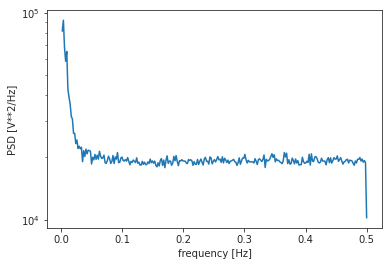

In [14]:
plt.semilogy(f[1:], Pxx_den[tsnr > thres].mean(0)[1:])
# plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

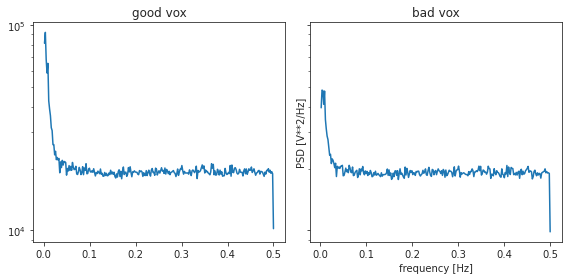

In [15]:
fig, axes = create_figure(1, 2, (8, 4), sharey='row')
axes[0].semilogy(f[1:], Pxx_den[tsnr > thres].mean(0)[1:])
axes[0].set_title('good vox')
axes[1].semilogy(f[1:], Pxx_den[tsnr <= thres].mean(0)[1:])
axes[1].set_title('bad vox')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

## Check Ca Missing

In [16]:
rest_normal, led_normal = [], []
for i in range(1, 10 + 1):
    for j in range(1, 3 +1):
        for k in [2, 4, 6]:
            led_normal.append((i, j, k))
        for k in [1, 3, 5, 7]:
            rest_normal.append((i, j, k))
len(rest_normal), len(led_normal), len(rest_normal) + len(led_normal)

(120, 90, 210)

In [17]:
pth = '/mnt/storage/hadi/Ca-fMRI/PreprocessedDataBIDS'

rest, led = [], []
for p in pathlib.Path(pth).rglob('*.nii.gz'):
    x = p.name.split('_')
    try:
        task = next(e for e in x if 'task' in e)
        task = task.split('-')[-1]
        
        sub = next(e for e in x if 'sub' in e)
        ses = next(e for e in x if 'ses' in e)
        run = next(e for e in x if 'run' in e)
        sub, ses, run = map(
            lambda s: int(re.findall(r"\d+", s).pop()),
            [sub, ses, run],
        )
        
        if task == 'led':
            led.append((sub, ses, run))
        elif task == 'rest':
            rest.append((sub, ses, run))
        else:
            print('???')
    except StopIteration:
        continue
        
led, rest = sorted(led), sorted(rest)
len(rest), len(led), len(rest) + len(led)

(113, 89, 202)

In [18]:
led_delta = sorted(set(led_normal).symmetric_difference(led))
rest_delta = sorted(set(rest_normal).symmetric_difference(rest))

rest_delta, led_delta

(
    [
        (2, 2, 7),
        (3, 1, 1),
        (3, 1, 2),
        (3, 1, 3),
        (3, 1, 4),
        (3, 1, 5),
        (3, 1, 6),
        (3, 1, 7),
        (3, 2, 1),
        (4, 3, 3),
        (4, 3, 7),
        (5, 3, 5),
        (8, 1, 7)
    ],
    [
        (2, 2, 7),
        (3, 1, 2),
        (3, 1, 3),
        (3, 1, 4),
        (3, 1, 5),
        (3, 1, 6),
        (3, 1, 7),
        (3, 2, 6),
        (6, 3, 2)
    ]
)

In [19]:
missing = [e for e in rest_delta if e[0] != 3]
missing += [(3, 1, 1), (3, 2, 1), (3, 2, 6), (6, 3, 2)]
missing.pop(missing.index((2, 2, 7)))
missing = sorted(missing)
missing

[
    (3, 1, 1),
    (3, 2, 1),
    (3, 2, 6),
    (4, 3, 3),
    (4, 3, 7),
    (5, 3, 5),
    (6, 3, 2),
    (8, 1, 7)
]

## BOLD (Gabe) Missing

In [20]:
rest_normal, led_normal = [], []
for i in range(1, 10 + 1):
    for j in range(1, 3 +1):
        for k in [2, 4, 6]:
            led_normal.append((i, j, k))
        for k in [1, 3, 5, 7]:
            rest_normal.append((i, j, k))
len(rest_normal), len(led_normal), len(rest_normal) + len(led_normal)

(120, 90, 210)

### Clean

In [21]:
pth = '/mnt/storage/hadi/Ca-fMRI/gabe_data/reoriented_data/cleaned_timeseries'

rest, led = [], []
for p in pathlib.Path(pth).rglob('*.nii.gz'):
    x = p.name.split('_')
    try:
        task = next(e for e in x if 'task' in e)
        task = task.split('-')[-1]
        
        sub = next(e for e in x if 'sub' in e)
        ses = next(e for e in x if 'ses' in e)
        run = next(e for e in x if 'run' in e)
        sub, ses, run = map(
            lambda s: int(re.findall(r"\d+", s).pop()),
            [sub, ses, run],
        )
        
        if task == 'led':
            led.append((sub, ses, run))
        elif task == 'rest':
            rest.append((sub, ses, run))
        else:
            print('???')
    except StopIteration:
        continue
        
led, rest = sorted(led), sorted(rest)
len(rest), len(led), len(rest) + len(led)

(115, 86, 201)

In [22]:
len(rest_normal), len(led_normal), len(rest_normal) + len(led_normal)

(120, 90, 210)

In [23]:
led_delta = sorted(set(led_normal).symmetric_difference(led))
rest_delta = sorted(set(rest_normal).symmetric_difference(rest))

rest_delta, led_delta

(
    [
        (2, 2, 7),
        (3, 1, 1),
        (3, 1, 2),
        (3, 1, 3),
        (3, 1, 4),
        (3, 1, 5),
        (3, 1, 6),
        (3, 1, 7),
        (5, 1, 5),
        (7, 2, 1),
        (8, 1, 7)
    ],
    [
        (1, 1, 4),
        (2, 2, 7),
        (3, 1, 2),
        (3, 1, 3),
        (3, 1, 4),
        (3, 1, 5),
        (3, 1, 6),
        (3, 1, 7),
        (3, 3, 2),
        (4, 3, 2),
        (6, 3, 2),
        (7, 1, 6)
    ]
)

In [24]:
missing = [e for e in rest_delta if e[0] != 3]
missing += [(1, 1, 4), (3, 1, 1)] #, (3, 2, 1), (3, 2, 6), (6, 3, 2)]
missing.pop(missing.index((2, 2, 7)))
missing = sorted(missing)
missing

[(1, 1, 4), (3, 1, 1), (5, 1, 5), (7, 2, 1), (8, 1, 7)]

### Raw

In [25]:
pth = '/mnt/storage/hadi/Ca-fMRI/gabe_data/reoriented_data/native_preprocessed_data'

rest, led = [], []
for p in pathlib.Path(pth).rglob('*.nii.gz'):
    x = p.name.split('_')
    try:
        task = next(e for e in x if 'task' in e)
        task = task.split('-')[-1]
        
        sub = next(e for e in x if 'sub' in e)
        ses = next(e for e in x if 'ses' in e)
        run = next(e for e in x if 'run' in e)
        sub, ses, run = map(
            lambda s: int(re.findall(r"\d+", s).pop()),
            [sub, ses, run],
        )
        
        if task == 'led':
            led.append((sub, ses, run))
        elif task == 'rest':
            rest.append((sub, ses, run))
        else:
            print('???')
    except StopIteration:
        continue
        
led, rest = sorted(led), sorted(rest)
len(rest), len(led), len(rest) + len(led)

(116, 90, 206)

In [26]:
led_delta = sorted(set(led_normal).symmetric_difference(led))
rest_delta = sorted(set(rest_normal).symmetric_difference(rest))

rest_delta, led_delta

(
    [
        (2, 2, 7),
        (3, 1, 1),
        (3, 1, 2),
        (3, 1, 3),
        (3, 1, 4),
        (3, 1, 5),
        (3, 1, 6),
        (3, 1, 7),
        (5, 1, 5),
        (8, 1, 7)
    ],
    [
        (2, 2, 7),
        (3, 1, 2),
        (3, 1, 3),
        (3, 1, 4),
        (3, 1, 5),
        (3, 1, 6),
        (3, 1, 7),
        (6, 3, 2)
    ]
)

In [27]:
missing = [e for e in rest_delta if e[0] != 3]
# missing += [(1, 1, 4), (3, 1, 1)] #, (3, 2, 1), (3, 2, 6), (6, 3, 2)]
missing.pop(missing.index((2, 2, 7)))
missing = sorted(missing)
missing

[(5, 1, 5), (8, 1, 7)]